In [1]:
import converter as cv
from qiskit.circuit import ParameterVector, QuantumCircuit, Parameter
from qiskit import Aer, execute
from qiskit.utils.quantum_instance import QuantumInstance
import pylab
import numpy as np
import converter as cv
import dill
from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools
from math import pi
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from qiskit.circuit import ParameterVector, QuantumCircuit, Parameter
from qiskit import execute, Aer, IBMQ, QuantumRegister, ClassicalRegister, BasicAer
def coding_bits(b):
    c = [b[n:n+7] for n,i in enumerate(b) if n%7==0]
    c_p=[]
    coding_0=[]
    for i in range(len(c)):
        for j in c[i]:
            c_p.append(str(j))
    np.asarray(c_p)
    c = [c_p[n:n+7] for n,i in enumerate(c_p) if n%7==0]
    for i in c:
        coding_0.append(''.join(i))
    return coding_0

class CircuitConversor:

    def __init__(self, nqubits, nparameters):
        gates = {}
        for n, suffix in enumerate(['0000','0001','0010','0011','0100','0101','0110','0111','1000','1001','1010','1011','1101','1110','1111','1100']):
            angle = (np.pi /8)*(n+1)
            gates['000'+suffix] = (self.make_rx_(angle), 1.0)
            gates['001'+suffix] = (self.make_cx(), 2.0)
            gates['010'+suffix] = (self.make_id(), 0.0)
            gates['011'+suffix] = (self.make_rx(angle), 1.0)
            gates['100'+suffix] = (self.make_rz(angle), 1.0)
            gates['101'+suffix] = (self.make_ry_(angle), 1.0)
            gates['110'+suffix] = (self.make_rz_(angle), 1.0)
            gates['111'+suffix] = (self.make_ry(angle), 1.0)
        self.gates = gates
        self.nqubits = nqubits
        self.register = QuantumRegister(nqubits, 'q')
        self.nparameters = nparameters
        self.nqubits = nqubits
        self.x = ParameterVector('x', nparameters)

    def __call__(self, coding_0):
        print(coding_0)
        circuit = QuantumCircuit(self.register)
        k = 0
        cost = 0
        for ndx, z in enumerate(coding_0):
            qubit = ndx % self.nqubits
            target = (ndx + 1) % self.nqubits
            fn, weight = self.gates[z]
            k = fn(circuit, k, qubit, target)
            cost += weight
        for i in range(k, self.nparameters):
            circuit.rz(self.x[i]*0, self.register[0])
        return circuit, cost

    def make_id(self):
        def operation(circuit, k, qubit, target):
            return k
        return operation

    def make_H(self):
        def operation(circuit, k, qubit, target):
            circuit.h(self.register[qubit])
            return k
        return operation

    def make_cx(self):
        def operation(circuit, k, qubit, target):
            circuit.cx(self.register[qubit], self.register[target])
            return k
        return operation

    def make_rx(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rx(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_ry(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.ry(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_rz(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rz(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation
    
    def make_rx_(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rx(angle,self.register[qubit])
            return k
        return operation

    def make_ry_(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.ry(angle,self.register[qubit])
            return k
        return operation

    def make_rz_(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rz(angle, self.register[qubit])
            return k
        return operation
    

import os
import psutil

class Fitness:

    def __init__(self, nqubits, nparameters, X, y, quantum_instance):
        self.nqubits = nqubits
        self.nparameters = nparameters
        self.cc = CircuitConversor(nqubits, nparameters)
        self.instance = quantum_instance
        self.X = X
        self.y = y

    def __call__(self, POP):
        try:
            return self.fitness(POP)
        except Exception as e:
            print(f'Exception happened during fitness():\n  {e}')
            process = psutil.Process(os.getpid())
            print(f'  RUSAGE_SELF: {process.memory_info()}')
        return 1000, 100000.0

    def fitness(self, POP):
        print('Invoked fitness')
        #Convertimos el individuo en el fenotipo (ansatz)
        fm, puertas = self.cc(coding_bits(POP))

2
['0110101', '1100101', '0110100', '1110111', '1110110', '1010100', '0110100', '0011100', '0000111', '1011011', '1001010', '0011010', '1000101', '1110101', '0101001', '1100010', '0011000', '1001101', '0000100', '1011111', '1101111', '1100011', '0001010', '1111110', '0101011', '1110011', '1101010', '0110101', '1111010', '1011110', '0100111', '0011011', '1110110', '0111010', '1101101', '1001000', '0010111', '1001001', '0010011', '1010101', '0011100', '0110100', '1111100', '1001100', '1011010', '0010001', '0100010', '1111001', '0011010', '1010010', '0100100', '0011000', '0110111', '1000111', '0100111', '1001101', '0011001', '0000000', '1010100', '1100100', '1110001', '0100001', '0101000', '0000000', '1101000', '0011011']


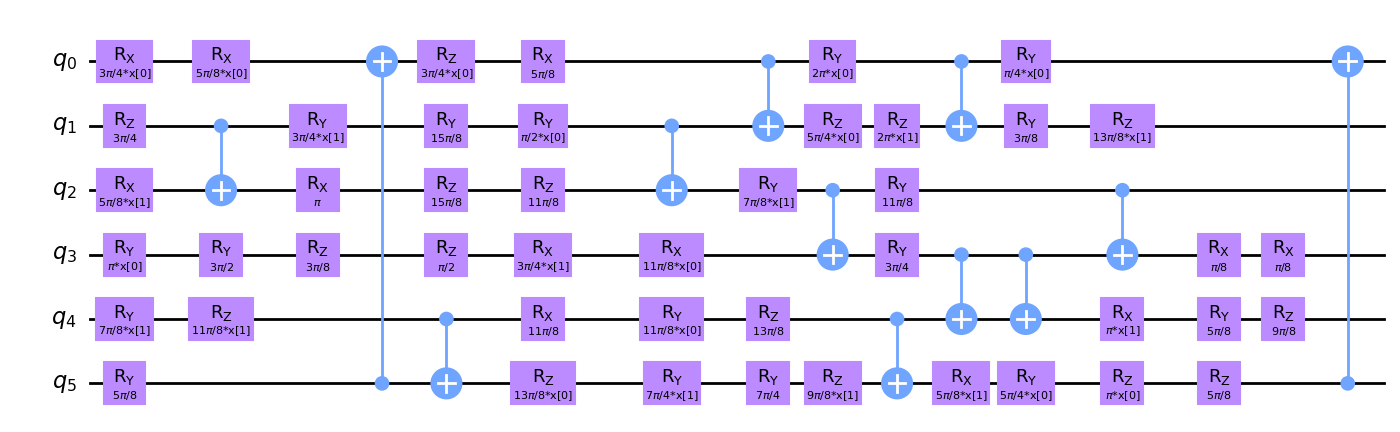

In [3]:
import pickle
path = r'C:\Users\sergi\Desktop\AUTOQML_CODE\COVID\COV_PCA_05\ind'
model = r'\tuples_0.9456521739130435_25.88819313169502.pkl'
with open(path+model, 'rb') as f:
    param,pop= pickle.load(f)
    
print(param)
cc = CircuitConversor(nqubits=6, nparameters=param)
fm, puertas = cc(coding_bits(pop))
fm.draw(output='mpl')